### Final Project: Music Genre Classification with CNN

### Setup and Imports

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


### Step 1: Dataset Selection and Loading

**Justification:**

- The GTZAN dataset is a supervised learning dataset with audio files labeled by music genre.
- It contains A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds) and is widely used in music genre classification studies.
- For our project, we plan to compare deep learning models (RNN/CNN) against traditional ML models.

In [78]:
# Function to load and explore the dataset
try:
    data_df = pd.read_csv("features_3_sec.csv")
    print("Dataset loaded successfully!")
except Exception as e:
    print("Error loading dataset:", e)

# Exploration of the dataset
print("\nFirst 5 records:")
print(data_df.head())

Dataset loaded successfully!

First 5 records:
            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.77

In [81]:
# Shape of the dataset
print("\nDataset shape:", data_df.shape)
print("\nStatistical summary:")
print(data_df.describe())


Dataset shape: (9990, 60)

Statistical summary:
        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              22

In [80]:
# Data types
print("\nData types:")
print(data_df.dtypes)


Data types:
filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_v

In [82]:
# Distribution of genres
print("\nGenre distribution in the dataset:")
print(data_df['label'].value_counts())


Genre distribution in the dataset:
label
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64


### Step 2: Data Cleaning

In [83]:
# Check and handle missing values
print("Missing values by column:")
print(data_df.isnull().sum())

Missing values by column:
filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean       

In [84]:
# Detect and remove outliers function using IQR method on numeric columns
def detect_outliers_iqr(data_df, column):
    """
    Detect outliers in a specified column using the IQR method.
    Returns a DataFrame containing only the outlier rows.
    """
    Q1 = data_df[column].quantile(0.25)
    Q3 = data_df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data_df[(data_df[column] < lower_bound) | (data_df[column] > upper_bound)]
    return outliers

def remove_outliers_iqr(data_df, column):
    """
    Removes outliers in the specified column using the IQR method.
    
    Returns:
        A new DataFrame with outlier rows removed.
    """
    Q1 = data_df[column].quantile(0.25)
    Q3 = data_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a mask that keeps only values within the bounds.
    mask = (data_df[column] >= lower_bound) & (data_df[column] <= upper_bound)
    df_clean = data_df[mask].copy()
    return df_clean

In [85]:
# Visualize numeric columns for outliers
numeric_cols = data_df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns to check for outliers:", numeric_cols)


Numeric columns to check for outliers: ['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']


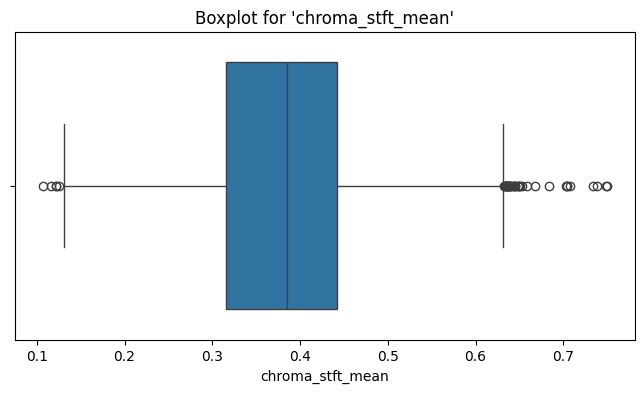

Detected 39 outlier(s) in 'chroma_stft_mean' using IQR method.


In [87]:
# Visualizing outliers for "chroma_stft_mean"
if 'chroma_stft_mean' in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=data_df['chroma_stft_mean'])
    plt.title("Boxplot for 'chroma_stft_mean'")
    plt.xlabel("chroma_stft_mean")
    plt.show()
    
    # Detect outliers for "chroma_stft_mean"
    outliers_chroma = detect_outliers_iqr(data_df, 'chroma_stft_mean')
    print(f"Detected {len(outliers_chroma)} outlier(s) in 'chroma_stft_mean' using IQR method.")


In [88]:
 # Remove outliers from the 'chroma_stft_mean' column.
data_df_clean = remove_outliers_iqr(data_df, 'chroma_stft_mean')
print("New shape after removing outliers from 'chroma_stft_mean':", data_df_clean.shape)

New shape after removing outliers from 'chroma_stft_mean': (9951, 60)


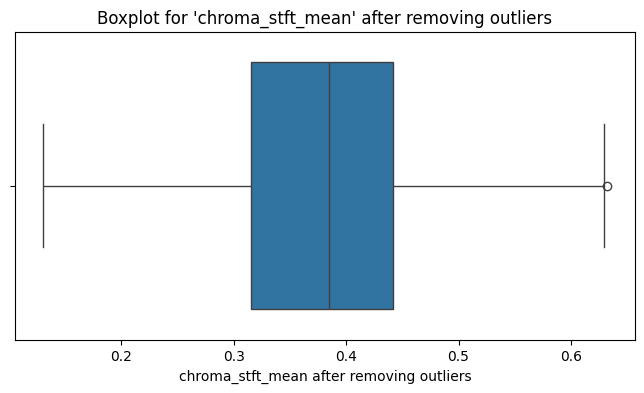

Detected 1 outlier(s) in 'chroma_stft_mean' using IQR method.


In [89]:
# Visualizing after removing outliers for "chroma_stft_mean"
if 'chroma_stft_mean' in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=data_df_clean['chroma_stft_mean'])
    plt.title("Boxplot for 'chroma_stft_mean' after removing outliers")
    plt.xlabel("chroma_stft_mean after removing outliers")
    plt.show()
    
    outliers_chroma = detect_outliers_iqr(data_df_clean, 'chroma_stft_mean')
    print(f"Detected {len(outliers_chroma)} outlier(s) in 'chroma_stft_mean' using IQR method.")

### Step 3: Data Exploration

In [90]:
# Statistical summaries of the clean dataset after outlier removal
print("\nStatistical summary of the clean dataset:")
print(data_df_clean.describe())


Statistical summary of the clean dataset:
        length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9951.0       9951.000000      9951.000000  9951.000000  9.951000e+03   
mean   66149.0          0.378697         0.085035     0.130743  2.683310e-03   
std        0.0          0.088895         0.009253     0.068147  3.589484e-03   
min    66149.0          0.130597         0.043849     0.001539  1.257168e-07   
25%    66149.0          0.315540         0.079916     0.083859  6.201435e-04   
50%    66149.0          0.384476         0.085150     0.121355  1.496230e-03   
75%    66149.0          0.441795         0.091120     0.176296  3.142374e-03   
max    66149.0          0.631682         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9951.000000           9.951000e+03              9951.000000   
mean              2195.408620           4.174557e+05              2240.748

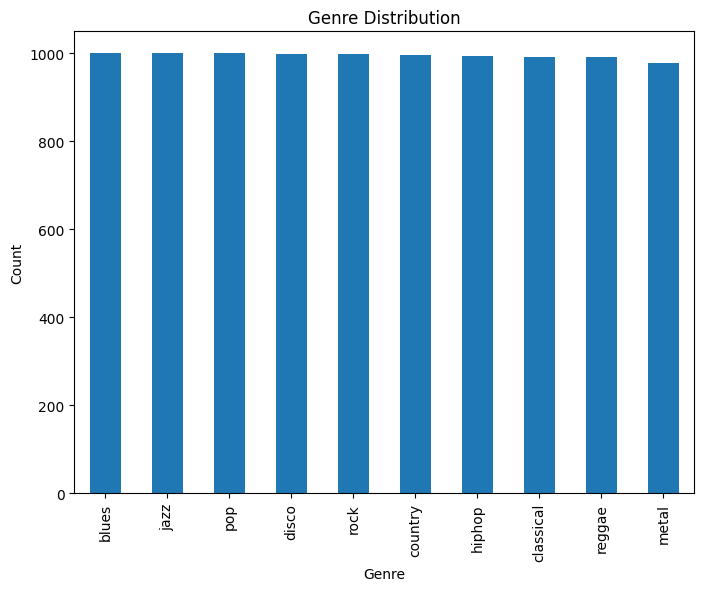

In [91]:
# Visualization: Distribution of genres
plt.figure(figsize=(8,6))
data_df_clean['label'].value_counts().plot(kind='bar')
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

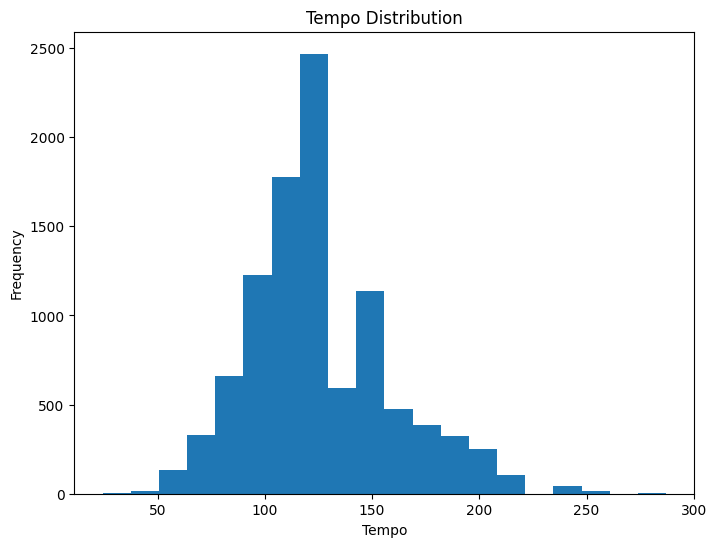

In [92]:
# Visualization: For any specific numeric feature (e.g., 'tempo')
if 'tempo' in data_df_clean.columns:
    plt.figure(figsize=(8,6))
    plt.hist(data_df_clean['tempo'], bins=20)
    plt.title("Tempo Distribution")
    plt.xlabel("Tempo")
    plt.ylabel("Frequency")
    plt.show()

**Loading some samples per genre from the dataset**

Rock   

Classical

### Step 4: Feature Engineering

In [93]:
# Dropping 'filename' column
columns_to_drop = []
if 'filename' in data_df_clean.columns:
    columns_to_drop.append('filename')

In [94]:
if columns_to_drop:
    data_df_clean = data_df.drop(columns=columns_to_drop)
    print(f"\nDropped columns: {columns_to_drop}")
    print("Data shape after dropping columns:", data_df_clean.shape)


Dropped columns: ['filename']
Data shape after dropping columns: (9990, 59)


In [ ]:
# Feature extraction: 
labels = data_df_clean.iloc[:, -1] # The last column is the label
convertor = LabelEncoder()
y = convertor.fit_transform(labels)
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
# Printing the first 5 labels
print(data_df_clean.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [102]:
# Scaling features

scaler = StandardScaler()
x = scaler.fit_transform(np.array(data_df_clean.iloc[:, :-1], dtype = float))
print("\nFeature matrix shape:", x.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (9990, 58)
Labels shape: (9990,)


In [103]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print("\nTraining feature shape:", x_train.shape)
print("Testing feature shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)



Training feature shape: (6693, 58)
Testing feature shape: (3297, 58)
Training labels shape: (6693,)
Testing labels shape: (3297,)


### Step 5: Model Selection

### Step 6: Hyperparameter Tuning

### Step 7: Save Models (Pickle Files)

### Step 8: Web Application (Flask or Streamlit)